  Trigger Date     Final P&L  Date-wise P&L  Moving Avg P&L
0   2024-03-21  -7519.999695            NaN             NaN
1   2024-03-21   2630.000305   10150.000000             NaN
2   2024-03-22 -10492.500305  -13122.500610             NaN
3   2024-03-26   2532.499695   13025.000000             NaN
4   2024-03-27  -8432.500458  -10965.000153    -4256.500092


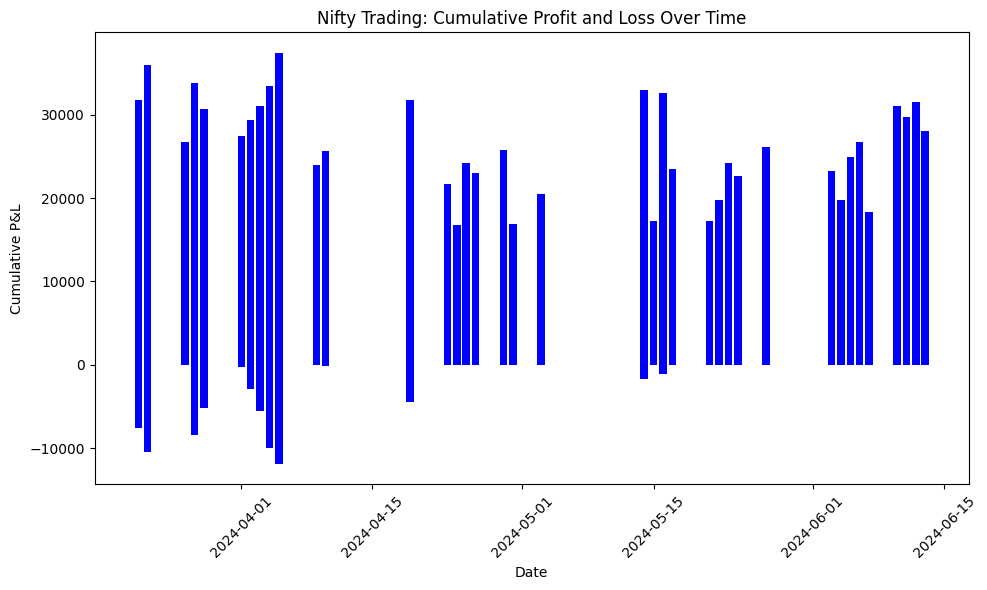

In [48]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Read the provided ratio_spread_df (replace file paths with your actual file names)
# Call_Long_CSV = 'C:\\Test-ratio_spread_df\\_DYNAMIC CONTRACT(INDICES_NIFTY 50, CE, ATM, -3, CURRENT, WEEKLY, SHORT, CANDLE).csv'
# Call_Short_CSV = 'C:\\Test-ratio_spread_df\\_DYNAMIC CONTRACT(INDICES_NIFTY 50, CE, ATM, -1, CURRENT, WEEKLY, LONG, CANDLE).csv'

# call_long_df = pd.read_csv(Call_Long_CSV, parse_dates=['Trigger Date'])
# call_short_df = pd.read_csv(Call_Short_CSV, parse_dates=['Trigger Date'])

# # Calculate cost based on trigger type
# call_long_df['Cost'] = call_long_df['Quantity'] * call_long_df['Price']
# call_short_df['Cost'] = call_short_df['Quantity'] * call_short_df['Price']

# # Concatenate vertically (along rows)
# ratio_spread_df = pd.concat([call_long_df, call_short_df], ignore_index=True)

# # Calculate cumulative P&L
# ratio_spread_df['Final P&L'] = ratio_spread_df['Cost'].cumsum()

# # Calculate date-wise P&L
# ratio_spread_df['Date-wise P&L'] = ratio_spread_df['Final P&L'].diff()

# # Calculate moving average of cumulative P&L (e.g., 30-day moving average)
# window = 5
# ratio_spread_df['Moving Avg P&L'] = ratio_spread_df['Final P&L'].rolling(window=window).mean()

# # Print the modified ratio_spread_dfFrame
# print(ratio_spread_df[['Trigger Date', 'Final P&L', 'Date-wise P&L', 'Moving Avg P&L']].head())


# # Plot the bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(ratio_spread_df['Trigger Date'], ratio_spread_df['Final P&L'], color='b')
# plt.xlabel('Date')
# plt.ylabel('Cumulative P&L')
# plt.title('Nifty Trading: Cumulative Profit and Loss Over Time')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

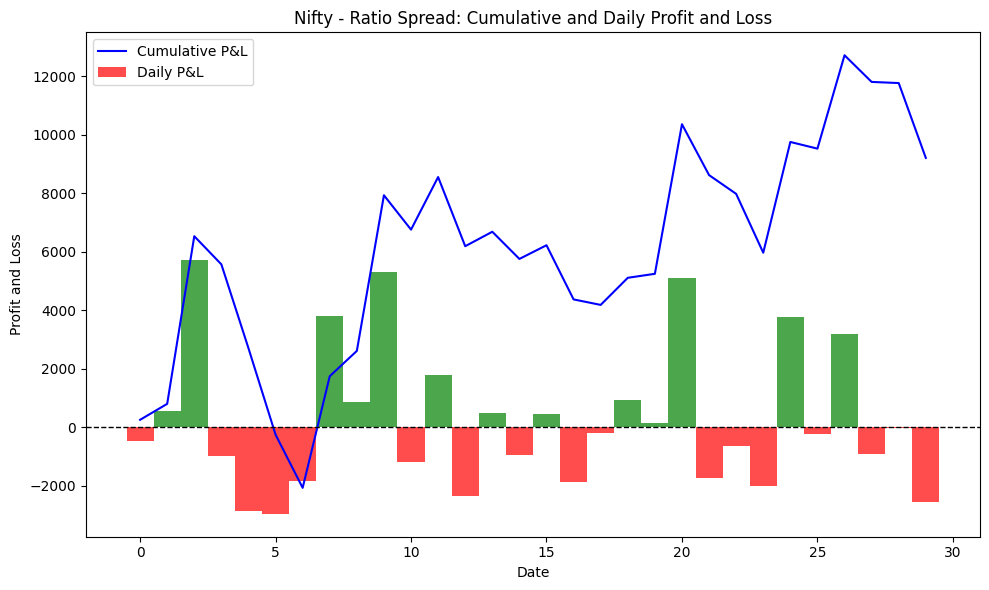

In [212]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def calculate_adjusted_cumulative_sum(df):
    # Initialize a dictionary to track cumulative P&L
    cumulative_pnl = {}
    Encost = 0  # Initialize entry cost

    # Iterate through each row
    for index, row in df.iterrows():
        date = row['Trigger Date']
        cost = row['Cost']

        # Adjust cumulative P&L based on trigger type (EN or EX)
        if row['Trigger type'] == 'EN':
            Encost += cost
            # print("encost date:", date, "encost:" , Encost)
        elif row['Trigger type'] == 'EX':
            # print("encost date:", date, "encost:", Encost, "excost:", cost)
            cumulative_pnl[date] = cumulative_pnl.get(date, 0) + (Encost + cost)
            Encost = 0

    # Convert dictionary to pandas Series
    # adjusted_cumulative_sum = pd.Series(cumulative_pnl)
    # Convert dictionary to pandas ratio_spread_dfFrame
    adjusted_cumulative_df = pd.DataFrame({
        'Date': list(cumulative_pnl.keys()),
        'PnL': list(cumulative_pnl.values())
    })

    # Set the Date column as the index
    adjusted_cumulative_df.set_index('Date', inplace=True)

    return adjusted_cumulative_df

Call_Long_CSV = 'C:\\Test-Data\\_DYNAMIC CONTRACT(INDICES_NIFTY 50, CE, ATM, -1, CURRENT, WEEKLY, LONG, CANDLE).csv'
Call_Short_CSV = 'C:\\Test-Data\\_DYNAMIC CONTRACT(INDICES_NIFTY 50, CE, ATM, -3, CURRENT, WEEKLY, SHORT, CANDLE).csv'
Put_Short_CSV = 'C:\\Test-Data\\_DYNAMIC CONTRACT(INDICES_NIFTY 50, PE, ATM, -9, CURRENT, WEEKLY, SHORT, CANDLE).csv'

call_long_df = pd.read_csv(Call_Long_CSV, parse_dates=['Trigger Date'])
call_short_df = pd.read_csv(Call_Short_CSV, parse_dates=['Trigger Date'])
put_short_df = pd.read_csv(Put_Short_CSV, parse_dates=['Trigger Date'])
call_long_df.columns = call_long_df.columns.str.strip()
call_short_df.columns = call_short_df.columns.str.strip()
put_short_df.columns = call_short_df.columns.str.strip()

# Adjust quantity for CE Long (2x) and CE Short (1x)
call_long_df['Quantity'] *= 2
put_short_df['Quantity'] *= 2
# Calculate cost for each trade
call_long_df['Cost'] = -call_long_df['Quantity'] * call_long_df['Price']
call_short_df['Cost'] = -call_short_df['Quantity'] * call_short_df['Price']
put_short_df['Cost'] = -put_short_df['Quantity'] * put_short_df['Price']

# Calculate adjusted cumulative P&L
call_long_df_adjusted = calculate_adjusted_cumulative_sum(call_long_df)
call_short_df_adjusted = calculate_adjusted_cumulative_sum(call_short_df)
put_short_df_adjusted = calculate_adjusted_cumulative_sum(put_short_df)
ratio_spread_df = pd.concat([call_long_df_adjusted, call_short_df_adjusted])
ratio_spread_n_pe = pd.concat([call_long_df_adjusted, call_short_df_adjusted,put_short_df_adjusted])

call_long_df_adjusted.to_csv('C:\\Test-Data\\Call_Longx2.csv')
call_long_df_adjusted.to_csv('C:\\Test-Data\\Call_shortx1.csv')
put_short_df_adjusted.to_csv('C:\\Test-Data\\Put_Shortx2.csv')
ratio_spread_df.to_csv('C:\\Test-Data\\RatioSpread.csv')
ratio_spread_n_pe.to_csv('C:\\Test-Data\\RatioSpread_n_PE.csv')

# Group ratio_spread_df by date and calculate cumulative P&L
ratio_spread_df_grouped = ratio_spread_df.groupby('Date')['PnL'].sum().cumsum()

# Calculate daily P&L
daily_pnl = ratio_spread_df_grouped.diff().fillna(0)

# Filter out days with zero profit and loss
filtered_ratio_spread_df_grouped = ratio_spread_df_grouped[daily_pnl != 0]

# Reset index to avoid gaps
filtered_ratio_spread_df_grouped.reset_index(drop=True, inplace=True)


# Create the consolidated ratio_spread_dfframe
consolidated_df = pd.DataFrame({
    'Date': filtered_ratio_spread_df_grouped.index,
    'Cumulative P&L': filtered_ratio_spread_df_grouped.values,
    'Daily P&L': daily_pnl[daily_pnl != 0]
})

consolidated_df['diff'] = consolidated_df['Daily P&L'].diff()
sign = np.sign(consolidated_df['diff'])
groupby_ = (sign != sign.shift(1)).cumsum()
consolidated_df['Sum_Sequal_P&L'] = consolidated_df.groupby(groupby_)['diff'].cumsum()

# Export the ratio_spread_df to a CSV file
consolidated_df.to_csv('C:\\Test-Data\\Final.csv')

# # Plot the cumulative P&L
# plt.figure(figsize=(10, 6))
# plt.plot(filtered_ratio_spread_df_grouped.index, filtered_ratio_spread_df_grouped.values, color='b', label='Cumulative P&L')
# plt.bar(filtered_ratio_spread_df_grouped.index, daily_pnl[daily_pnl != 0], color=['g' if pnl >= 0 else 'r' for pnl in daily_pnl[daily_pnl != 0]], alpha=0.7, label='Daily P&L', width=1)
# plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
# plt.xlabel('Date')
# plt.ylabel('Profit and Loss')
# plt.title('Nifty - Ratio Spread : Cumulative and Daily Profit and Loss')
# #plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# print("Highest Loss:",round(consolidated_df['Daily P&L'].min()))
# print("Largest Losing streak:",round(consolidated_df['Sum_Sequal_P&L'].min()))
# print("Max Drawdown:",round(consolidated_df['Cumulative P&L'].min()))

# print("Largest Profit:",round(consolidated_df['Daily P&L'].max()))
# print("Largest winning streak:",round(consolidated_df['Sum_Sequal_P&L'].max()))
# print("Max Profit:",round(consolidated_df['Cumulative P&L'].max()))

# Convert date strings to datetime objects
consolidated_df['Date'] = pd.to_datetime(consolidated_df['Date'])

# Your existing plot code
plt.figure(figsize=(10, 6))
plt.plot(filtered_ratio_spread_df_grouped.index, filtered_ratio_spread_df_grouped.values, color='b', label='Cumulative P&L')
plt.bar(filtered_ratio_spread_df_grouped.index, daily_pnl[daily_pnl != 0], color=['g' if pnl >= 0 else 'r' for pnl in daily_pnl[daily_pnl != 0]], alpha=0.7, label='Daily P&L', width=1)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Profit and Loss')
plt.title('Nifty - Ratio Spread: Cumulative and Daily Profit and Loss')
plt.legend()
plt.tight_layout()

# Annotate the graph with additional information
# plt.annotate(f'Highest Loss: {round(consolidated_df["Daily P&L"].min())}', xy=(datetime(2024, 6, 15), consolidated_df['Daily P&L'].min()), xytext=(-30, -50), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate(f'Highest Loss: {round(consolidated_df["Daily P&L"].min())}', xy=(datetime(2024, 6, 15), consolidated_df['Daily P&L'].min()), xytext=(-30, -50), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

#plt.annotate(f'Largest Losing Streak: {round(consolidated_df["Sum_Sequal_P&L"].min())}', xy=(datetime(2024, 6, 20), consolidated_df['Sum_Sequal_P&L'].min()), xytext=(-30, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate(f'Max Drawdown: {round(consolidated_df["Cumulative P&L"].min())}', xy=(datetime(2024, 6, 25), consolidated_df['Cumulative P&L'].min()), xytext=(-30, -50), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

plt.annotate(f'Largest Profit: {round(consolidated_df["Daily P&L"].max())}', xy=(datetime(2024, 6, 10), consolidated_df['Daily P&L'].max()), xytext=(-30, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='green'))
# plt.annotate(f'Largest Winning Streak: {round(consolidated_df["Sum_Sequal_P&L"].max())}', xy=(datetime(2024, 6, 5), consolidated_df['Sum_Sequal_P&L'].max()), xytext=(-30, -50), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='green'))

#plt.annotate(f'Max Profit: {round(consolidated_df["Cumulative P&L"].max())}', xy=(datetime(2024, 6, 1), consolidated_df['Cumulative P&L'].max()), xytext=(-30, 30), textcoords='offset points', arrowprops=dict(arrowstyle='->', color='green'))

plt.show()






In [199]:
# import numpy as np
# import pandas as pd
# my_df = pd.ratio_spread_dfFrame({'col_1': [1,2,5,6,4,3,7,8,9,11,14]})
# my_df['diff'] = my_df['col_1'].diff()

# sign = np.sign(my_df['diff'])
# groupby_ = (sign != sign.shift(1)).cumsum()
# print(groupby_)
# my_df['cond_sum'] = my_df.groupby(groupby_)['diff'].cumsum()
# print(my_df)

0     1
1     2
2     2
3     2
4     3
5     3
6     4
7     4
8     4
9     4
10    4
Name: diff, dtype: int64
    col_1  diff  cond_sum
0       1   NaN       NaN
1       2   1.0       1.0
2       5   3.0       4.0
3       6   1.0       5.0
4       4  -2.0      -2.0
5       3  -1.0      -3.0
6       7   4.0       4.0
7       8   1.0       5.0
8       9   1.0       6.0
9      11   2.0       8.0
10     14   3.0      11.0


In [ ]:
# # Identify consecutive negative sequences
# true_sequences = consolidated_df[consolidated_df['Daily P&L'] < 0]

# print(true_sequences.min())

# # Filter out the negative values
# negative_cumulative_pnl = true_sequences['Daily P&L'][true_sequences['Daily P&L'] < 0]

# # Identify consecutive negative sequences
# negative_sequences = (negative_cumulative_pnl != negative_cumulative_pnl.shift()).cumsum()

# #find consecutive positives (curr value must be pos, and either before or after value)
# is_pos = consolidated_df['Daily P&L'].ge(0)
# consec_pos = (is_pos & is_pos.shift(1)) | (is_pos & is_pos.shift(-1))

# #group values by changes in consec positives
# consec_group = consec_pos.ne(consec_pos.shift(1)).cumsum()

# #count consecutive negatives within each group, then set consec_pos groups to 0
# #(I think this can be done w/out a groupby but I can't figure it out)
# atest = consec_pos.groupby(consec_group).cumcount().add(1)


# # Calculate the sum of consecutive negative losses
# Largest_Loss = negative_cumulative_pnl.groupby(negative_sequences).sum().min()

# # print('max')
# # print(negative_cumulative_pnl.groupby(negative_sequences).sum())
# # # Calculate the count of consecutive loss days
# # consecutive_loss_count = negative_cumulative_pnl.groupby(negative_sequences).size()


# # print("Consecutive Loss Days Count:")
# # print(consecutive_loss_count)



# # Assuming you have the consolidated_df ratio_spread_dfFrame with cumulative and daily P&L

#  #Filter out the negative values
# # negative_daily_pnl = consolidated_df['Daily P&L'][consolidated_df['Daily P&L'] < 0]

# # # Identify consecutive negative sequences
# # negative_sequences = (negative_cumulative_pnl != negative_cumulative_pnl.shift()).cumsum()
# # losses = consolidated_df.groupby(negative_sequences)['Daily P&L'].cumsum()
# # group_numbers = losses.astype(int).diff().ne(0).cumsum()

# # # Calculate cumulative sums within each group
# # cumulative_sums = losses.groupby(group_numbers).cumsum()

# # # Sum the largest negative sequence
# # largest_negative_sum = cumulative_sums.min()

# # print("Largest Sequential Negative Sum:", largest_negative_sum)





